# Figure 5: part 2

In this script, 5hmC is studied from a bin-by-bin level. The genome is broken into bins of approximately 1kb. The average 5hmC% of these bins is used to produce genome-wide mean and then individual bins are compared against this to produce a log2 difference. This is done in a non-strand-specific manner. 

Having identified this, these bins will then be studied for feature content using pybedtools. Each bin effectively represents a region in a bed file, and can be intersected against another bed file containing feature elements. This will help to identify preferentiality between feature types for 5hmC. The null hypothesis posits that 5hmC is distributed randomly across bins, and is not preferentially associated with any particular gene feature.  

In [1]:
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth
import pandas as pd

dry = True

if dry == True:
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_stranded_sub.bed'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    del nano_mc_df
    tab_df = pd.read_csv(tab_bed_path, sep="\t", names=["chromosome", "chromStart", "chromEnd", "percentMeth", "strand"])

else:
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_stranded.bed'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))
    del nano_mc_df
    tab_df = pd.read_csv(tab_bed_path, sep="\t", names=["chromosome", "chromStart", "chromEnd", "percentMeth", "strand"]) 

In [2]:
import pandas as pd
import numpy as np 
import pyranges as pr

def addStrandsToTAB(tab_pr):
    stranded_tab_bed = pr.read_bed('./data/TAB_data/CRR008807_TAB_cytosine_report.tsv.CpG_report_strands.zero.bed')
    return tab_pr.join(stranded_tab_bed).drop(["Start_b", "End_b"])

def makePyrange(df):
    if "strand" in df.columns:
        df["Chromosome"], df["Start"], df["End"], df["Strand"] = df["chromosome"], df["chromStart"], df["chromEnd"], df["strand"]
        df = df[["Chromosome", "Start", "End", "Strand", "percentMeth"]]
        return  pr.PyRanges(df)
    else: 
        df["Chromosome"], df["Start"], df["End"]= df["chromosome"], df["chromStart"], df["chromEnd"]
        df = df[["Chromosome", "Start", "End", "percentMeth"]]
        return  addStrandsToTAB(pr.PyRanges(df))

def clusterPyrangeToDF(pr):
    tiled_pr = pr.tile(1000, strand=True).cluster(slack=-1, strand=True)
    cluster_pr = tiled_pr.merge(slack=-1, count=True, strand=True)
    cluster_pr = cluster_pr.insert(tiled_pr.apply(f=lambda df: df.groupby(["Cluster"])["percentMeth"].mean(), as_pyranges=False))
    return cluster_pr.as_df()

def log2FromMean(df):
    meth_mean = np.mean(df["percentMeth"])
    with np.errstate(divide="ignore"):
        log2ratio = np.log2(
            np.divide(df["percentMeth"], meth_mean))
    return log2ratio

def methodWrapper(df):
    pr = makePyrange(df)
    df_from_pr = clusterPyrangeToDF(pr)
    df_from_pr["log2FromMean"] = log2FromMean(df_from_pr)
    return df_from_pr

def main():
    nano_binned_df = methodWrapper(nano_hmc_df)
    tab_binned_df = methodWrapper(tab_df)
    merged = pd.merge(nano_binned_df, tab_binned_df, "inner", ["Chromosome", "Start", "End", "Strand"], suffixes=["_Nanopore", "_TAB"])
    return merged.replace(-np.inf, np.nan)


In [11]:
hmc_pr = pr.PyRanges(main())
feature_bed_pr = pr.read_bed('./feature_references/promoters/mm39_EPD_promoters.bed')

feature_overlap_df = hmc_pr.join(feature_bed_pr, slack=-1, suffix="_Promoter", strandedness="same").as_df()
feature_overlap_df

,Chromosome,Start,End,Strand,Count_Nanopore,percentMeth_Nanopore,log2FromMean_Nanopore,Count_TAB,percentMeth_TAB,log2FromMean_TAB,Start_Promoter,End_Promoter,Name,Score,Strand_Promoter,ThickStart,ThickEnd
0,chr1,4878000,4879000,+,68,1.766765,-2.330539,6,2.777778,-1.856142,4878068,4878128,Lypla1_1,900,+,4878117,4878128
1,chr1,4927000,4928000,+,40,4.699750,-0.919065,4,0.000000,NaN,4927964,4928024,Tcea1_1,900,+,4928013,4928024
2,chr1,5153000,5154000,+,63,0.609683,-3.865519,6,0.000000,NaN,5153302,5153362,Atp6v1h_1,900,+,5153351,5153362
3,chr1,5658000,5659000,+,16,0.446250,-4.315725,9,2.121212,-2.245185,5658643,5658703,Oprk1_1,900,+,5658692,5658703
4,chr1,6429000,6430000,+,41,1.315854,-2.755650,4,11.354167,0.175076,6429461,6429521,Alkal1_1,900,+,6429510,6429521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,chr1,69725000,69726000,-,19,1.754211,-2.340827,2,0.000000,NaN,69725098,69725158,Ikzf2_1,900,-,69725098,69725109
337,chr1,71142000,71143000,-,41,1.975122,-2.169707,4,12.208625,0.279755,71142092,71142152,Bard1_1,900,-,71142092,71142103
338,chr1,71454000,71455000,-,15,5.734667,-0.631939,12,8.058892,-0.319492,71454040,71454100,Abca12_1,900,-,71454040,71454051
339,chr1,72251000,72252000,-,84,0.709643,-3.646484,5,3.529412,-1.510646,72251407,72251467,Mreg_1,900,-,72251407,72251418


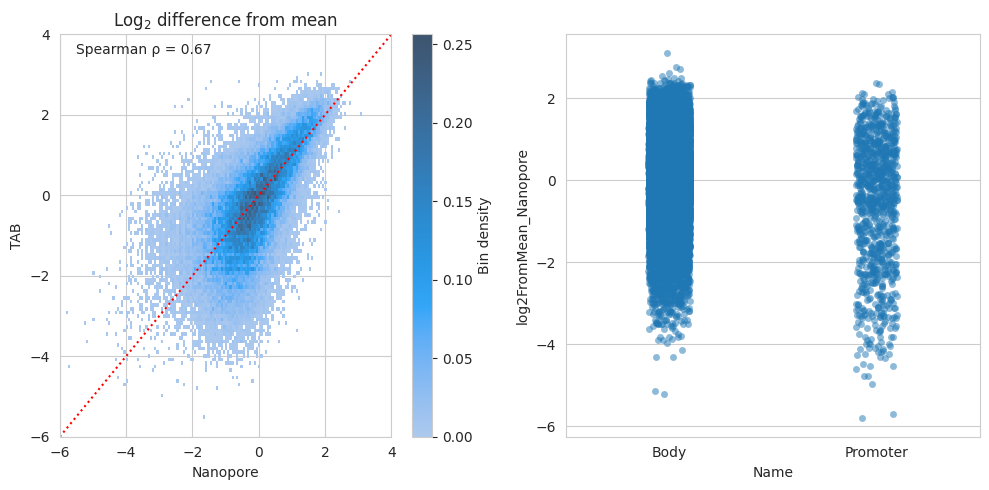

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, fig)

ax1 = fig.add_subplot(gs[0, 0])

sns.histplot(main().dropna(), x= "log2FromMean_Nanopore", y="log2FromMean_TAB", ax=ax1, cbar=True, cbar_kws={"label" : "Bin density"}, stat="density")
ax1.set_title("Log$_{2}$ difference from mean")

rho = stats.spearmanr(
    main().dropna()["log2FromMean_Nanopore"],
    main().dropna()["log2FromMean_TAB"]
    )[0]

ax1.text(-5.5, 3.5, "Spearman \u03C1 = {rho:.2f}".format(rho=rho))
ax1.plot(np.arange(-6, 5, 1), np.arange(-6, 5, 1), ls=":", c="r")
ax1.set_xlabel("Nanopore")
ax1.set_ylabel("TAB")
ax1.set_xlim((-6, 4))
ax1.set_ylim((-6, 4))

ax2 = fig.add_subplot(gs[0, 1])
sns.stripplot(feature_overlap_df.dropna(), x="Name", y="log2FromMean_Nanopore", ax=ax2, alpha=0.5)

fig.tight_layout()